## Introduction

Dialect identification is the process of determining the specific dialect or regional variety of a language that a speaker belongs to. In this project, I will be developing a model for identifying American regional dialects, using their acoustic characteristics rather than vocabulary. There are a variety of acoustic cues that distinguish these dialects, such as rhoticity, the cot-caught merger, and so on.

If you think about it, a person’s speech could contain characteristics of more than one dialect. So, soft clustering would be an interesting approach for this task. Under this clustering method, a data point could belong to more than one cluster rather than just one.

Soft clustering can be done through Gaussian Mixture Models (GMMs). They’re similar to K-means but factor variance, computing the probability of a data point belonging to each cluster.

## Dataset

TIMIT is a read speech corpus containing speech samples from speakers across the US. Each speaker is conveniently labeled as belonging to one of the following dialect regions:

| Region # | Region name              | # Speakers |
|----------|--------------------------|------------|
| DR1      | New England              | 49         |
| DR2      | Northern                 | 102        |
| DR3      | North Midland            | 102        |
| DR4      | South Midland            | 100        |
| DR5      | Southern                 | 98         |
| DR6      | New York City            | 46         |
| DR7      | Western                  | 100        |
| DR8      | Army Brat (moved around) | 33         |

There are relatively less New England and New York City speakers, so I will be merging these groups into one region. Additionally, army brat isn’t relevant, so I will be ignoring it.

For reference, here are my new regions:

| Region # | Region name              | # Speakers |
|----------|--------------------------|------------|
| DR1      | New England & NYC        | 95         |
| DR2      | Northern                 | 102        |
| DR3      | North Midland            | 102        |
| DR4      | South Midland            | 100        |
| DR5      | Southern                 | 98         |
| DR6      | Western                  | 100        |

The corpus does have some drawbacks for this task, however. Nour-Eddine and Abdelkader (2015) propose a GMM based Arabic Maghreb Dialect identification system, using about 50~ hours of data for each dialect. The total duration of TIMIT is about 5.38 hours, suggesting that this is not enough data to achieve the best results with this type of model. Additionally, it’s somewhat old (1993) and may not generalize well to modern speech.

## Approach

To extract features from the audio, I will take their mel-frequency cepstral coefficients (MFCCs). MFCCs capture the most salient information of the signal with respect to how we perceive audio (our perception is logarithmic.) The resulting representation is a sequence of feature vectors. The 1st coefficient represents overall energy, the next few represent formants, and so on. Around 12-13 MFCCs are standard.

Then, a GMM will be trained for each dialect region's MFCCs. In other words, each GMM during training will only see examples from one dialect. The idea behind this is that a single GMM will represent the distribution of speakers in a dialect region, (ideally) picking up some characteristic acoustic cues in the process.

The output of a single GMM represents the likelihood that a speaker’s speech sample belongs to its assigned dialect region. These likelihoods will then be converted into probabilities by normalizing them between 0 and 1 across all models. This then yields the probability of the sample belonging to each dialect region. The final output can be further interpreted as the dialectical composition of the speaker’s speech. For instance, if the output for a sample is 80% DR1 and 20% DR2, this could indicate that the speaker primarily has a New England/NYC accent with some northern influence.

## Implementation

In [1]:
import numpy as np
import glob
import librosa
from scipy.fft import fft
from sklearn.mixture import GaussianMixture

In [2]:
n_regions = 6 # Ignore army brat
train = []
test = []

for i in range(1, n_regions + 2):
    f1 = glob.glob(f'TIMIT/data/TRAIN/DR{i}/*/*.wav')
    f2 = glob.glob(f'TIMIT/data/TEST/DR{i}/*/*.WAV')
    if i == 6: # Append region 6 to 1
        train[0] += f1
        test[0] += f2
    else:
        train.append(f1)
        test.append(f2)

In [3]:
# Get MFCCs from a list of wav files
def get_mfccs(wavs):
    mfccs = []
    for w in wavs:
        y, _ = librosa.load(w, sr=16000)
        m = librosa.feature.mfcc(y=y, hop_length=160, n_mfcc=13, win_length=400)
        mfccs.append(m)
    
    # Get correct shape
    mfccs = np.transpose(np.concatenate(mfccs, axis=1))
    return mfccs

train_mfccs = []

for t in train:
    mfccs = get_mfccs(t)
    train_mfccs.append(mfccs)

In [4]:
# Combine mfccs for each dialect region to get global mean and std
combined_mfccs = np.concatenate(train_mfccs)
mean = combined_mfccs.mean(axis=0)
std = combined_mfccs.std(axis=0)

# Normalize mfccs for each dialect region
for i in range(n_regions):
    train_mfccs[i] = (train_mfccs[i] - mean) / std

In [21]:
gmm_models = []

# Train GMM for each region
for i in range(n_regions):
    gmm = GaussianMixture(n_components=127)
    gmm.fit(train_mfccs[i])
    
    gmm_models.append(gmm)
    print(f"Trained GMM for region {i+1}")

Trained GMM for region 1
Trained GMM for region 2
Trained GMM for region 3
Trained GMM for region 4
Trained GMM for region 5
Trained GMM for region 6


## Evaluation

In [8]:
# If soft, returns the probabilities of a sample belonging to each dialect region
# else, returns dialect region the sample has the highest likelihood of belonging to
def predict_dialect(mfcc_sample, soft=True):
    likelihoods = np.array([gmm.score(mfcc_sample) for gmm in gmm_models])
    if soft:
        likelihoods = np.exp(likelihoods)
        p = 100 * (likelihoods / np.sum(likelihoods)) # Convert to probabilities
        return p
    else:
        return np.argmax(likelihoods) + 1  # Add 1 to match dialect regions

In [22]:
correct = 0
total = 0

for i in range(n_regions):
    
    cur_correct = 0
    cur_total = len(test[i])
    
    for utterance in test[i]:
        mfcc = get_mfccs([utterance])
        mfcc = (mfcc - mean) / std # Normalize
        prediction = predict_dialect(mfcc, False)
    
        cur_correct += 1 if prediction == (i + 1) else 0
    
    # Region accuracy
    print(f'Region {i + 1}: {cur_correct / cur_total}')
    correct += cur_correct
    total += cur_total

# Total accuracy
print(f'Total: {correct / total}')

Region 1: 0.22272727272727272
Region 2: 0.2653846153846154
Region 3: 0.23076923076923078
Region 4: 0.128125
Region 5: 0.175
Region 6: 0.24782608695652175
Total: 0.2070063694267516


The models aren't performing well. In spite of this, I would like to demonstrate soft clustering using samples from my voice.

In [13]:
# Reformats model output to enhance readability
def format_prediction(pred, n_digits=2):
    pred = {
        'New England and NYC': round(pred[0], n_digits),
        'Northern': round(pred[1], n_digits),
        'North Midland': round(pred[2], n_digits),
        'South Midland': round(pred[3], n_digits),
        'Southern': round(pred[4], n_digits),
        'Western': round(pred[5], n_digits)
    }
    sort_pred = {k: v for k, v in sorted(pred.items(), key=lambda item: item[1], reverse=True)}
    
    return sort_pred;

In [23]:
my_mp3 = glob.glob(f'*1.mp3')
my_mfcc = get_mfccs(my_mp3)
my_mfcc = (my_mfcc - mean) / std

format_prediction(predict_dialect(my_mfcc))

{'New England and NYC': 96.01,
 'North Midland': 2.5,
 'Northern': 0.63,
 'South Midland': 0.58,
 'Southern': 0.25,
 'Western': 0.03}

For context, I'm from the New England and NYC region, but spent most of my life in the north midland region. The results somewhat indicate this (north midland should be much higher), but I'm dismissing this as a coincidence given how poorly the models are performing. 

# Model Selection

To select the number of components I used for my GMMs, I used the Bayesian information criterion (BIC). A lower score is generally better.

In [19]:
import matplotlib.pyplot as plt

n_components_range = range(115, 128 + 1)
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(train_mfccs[1])
    bic_scores.append(gmm.bic(train_mfccs[1]))

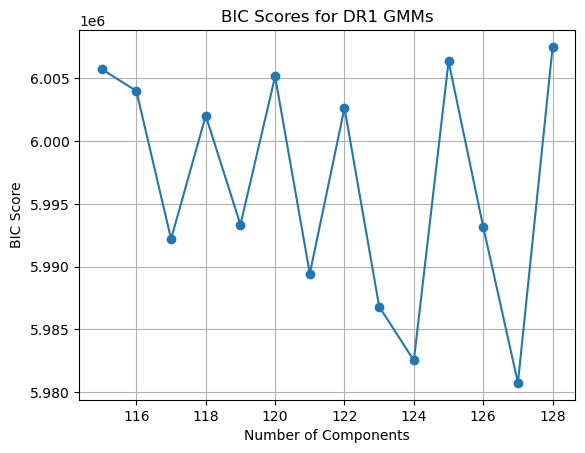

In [29]:
# Plot BIC scores
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Scores for DR1 GMMs')
plt.grid(True)
plt.show()